In [57]:
#file Locations
testTxtLocation ="/Users/pranav/Desktop/CS584/HW4/TestImage.txt"
outputTxtLocation="/Users/pranav/Desktop/CS584/HW4/outputImage.txt"

In [58]:
import numpy
from sklearn.preprocessing import Normalizer
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import  PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [59]:
k = numpy.loadtxt(testTxtLocation, delimiter=',')

In [60]:
k.shape

(10000, 784)

## Data scaling and normalization

In [61]:
k = Normalizer().fit(k).transform(k)  
scaledData=k/255.0

In [62]:
scaledData[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [63]:
scaledData = scaledData.reshape([-1,28,28,1])

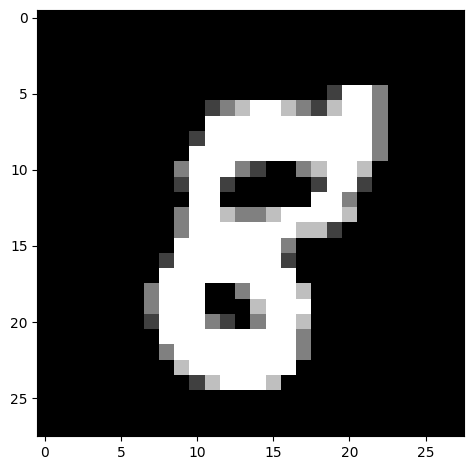

In [64]:
plt.imshow(scaledData[100],cmap='gray')

In [65]:
def averagingPixels(pixels):
    pixels=cv2.blur(pixels,(1,1))
    return pixels

In [66]:
def gaussianPixels(pixels):
    pixels= cv2.GaussianBlur(pixels,(5,5),0)
    return pixels

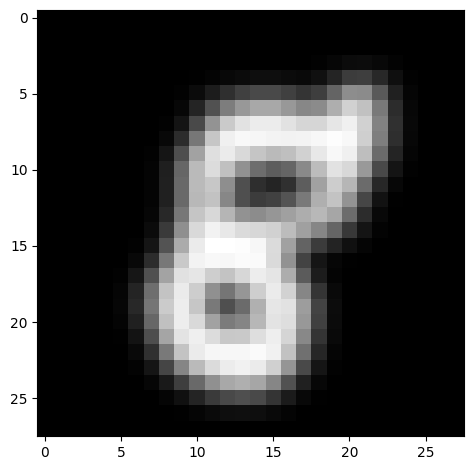

In [67]:
plt.imshow(averagingPixels(gaussianPixels(scaledData[100])), cmap='gray')

In [68]:
dataTransformed = []
for i in range(scaledData.shape[0]):
    dataG=averagingPixels(scaledData[i])
    dataTransformed.append(gaussianPixels(dataG).reshape(-1,784))
avgData = numpy.array(dataTransformed)

In [69]:
data = avgData.reshape(avgData.shape[0],avgData.shape[-1])

In [70]:
data.shape

(10000, 784)

## Reducing Dimensionality by applying Truncated SVD and tSNE

In [71]:
data= TruncatedSVD(n_components=50).fit_transform(data)

In [72]:
dataTsne = TSNE(n_components=2, n_iter=10000, early_exaggeration=26).fit_transform(data)
newDataTransform = MinMaxScaler(feature_range=(1,1000)).fit_transform(dataTsne)

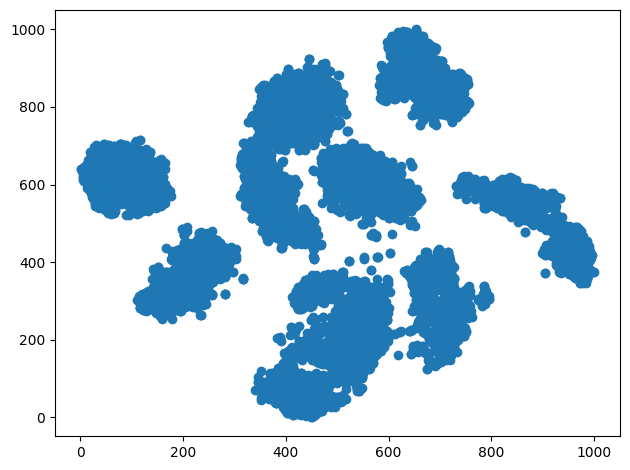

In [73]:
plt.scatter(newDataTransform[:,0], newDataTransform[:,1])

## Applying K-Mean Algorithm

In [74]:
def randomK(data,k,random):
    for i in range(k):
        indices = numpy.random.randint(0, data.shape[0], size=data.shape[1])
        random.append(indices)
    return random

In [75]:
def buildCentroid(data,build_centroid,currentCentroid):
    for j in range(len(currentCentroid)):
        build_centroid.append(data[currentCentroid[j],j])
    return build_centroid

In [76]:
def assignCentroid(centroed,random,data):
    for i in range(len(random)):
        currentCentroid = random[i]
        buildCentroidArray = []
        buildCentroidArray = buildCentroid(data,buildCentroidArray,currentCentroid)
        centroed.append(buildCentroidArray)
    return centroed

In [77]:
def getCentroid(data, k):
    random = []
    centroed = []
    random=randomK(data,k,random)
    centroed=assignCentroid(centroed,random,data)
    centroids=numpy.array(centroed)
    return centroids

In [78]:
def initializeClustersArray(size,clustersArray):
    for i in range(size):
            clustersArray[i] = []
    return clustersArray

In [79]:
def appendClusterWithData(assignClstr,clustersArray,dataX):
    for i in range(assignClstr.shape[0]):
        clustersArray[assignClstr[i]].append(dataX[i])
    return clustersArray

In [80]:
def restartCondition(size,clustersArray,data,restart,centroids):
    for i in range(size):
        if len(clustersArray[i]) == 0:
            centroids = getCentroid(data, size)
            restart = True
    return centroids,restart

In [81]:
def determineMean(clustersArray,index):
    temArr=numpy.array(clustersArray[index])
    mean=numpy.mean(temArr ,axis=0)
    return mean

In [82]:
def appendClusterWithMean(size,centroid_of_cluster,clustersArray):
    for i in range(size):
        centroid_of_cluster.append(determineMean(clustersArray,i))
    return centroid_of_cluster

In [83]:
def runKmeanClustering(size, dataX, centroids):
    iterCount = 0
    while True:
        iterCount = iterCount+1
        dist = euclidean_distances(dataX, centroids)
        restart = False
        clustersArray = {}
        finalcentroidCluster = []
        assignClstr  = numpy.argmin(dist, axis=1)
        clustersArray = initializeClustersArray(size,clustersArray)
        clustersArray = appendClusterWithData(assignClstr,clustersArray,dataX)
        centroids,restart=restartCondition(size,clustersArray,data,restart,centroids)
        if restart:
            continue
        finalcentroidCluster=appendClusterWithMean(size,finalcentroidCluster,clustersArray)
        if numpy.array_equal(finalcentroidCluster, centroids):
            return centroids, assignClstr
        else:
            centroids = numpy.array(finalcentroidCluster)

In [84]:
def reshapeReq(arr):
    return arr.reshape(1,-1)

In [85]:
def calculateSumOfSquareDistance(assignClstr,centroid,ssdistance,data):
    length=assignClstr.shape[0]
    for i in range(length):
        di = euclidean_distances(reshapeReq(data[i]), reshapeReq(centroid[assignClstr[i]]))
        ssdistance += (di*di)
    return ssdistance

In [86]:
def calculateInertia(data, centroid, assignClstr):
    ssdistance = 0
    centroid = numpy.array(centroid)
    assignClstr = numpy.array(assignClstr)
    ssdistance = calculateSumOfSquareDistance(assignClstr,centroid,ssdistance,data)
    return ssdistance

In [87]:
def minInertia(intertiaSelected):
    return numpy.argmin(intertiaSelected)

In [88]:
def selectClusterAndInertia(clusterandInertia,clustersSelected,intertiaSelected,num_iteration,k,train_data):
    for i in range(num_iteration):
        k_centroids, assigned_cluster = runKmeanClustering(k, train_data, getCentroid(train_data,k))
        clustersSelected.append(assigned_cluster)
        intertiaSelected.append(calculateInertia(train_data,k_centroids,assigned_cluster))
    return clusterandInertia,intertiaSelected

In [89]:
def runKmeans(train_data, clusters, num_iteration):
    clusterandInertia = []
    processingCluster = []
    
    
    for cluster in clusters:
        processingCluster.append(cluster)
    
    for k in processingCluster:
        clustersSelected =[]
        intertiaSelected = []
        print("processing cluster of size(k)=", k)
        clusterandInertia,intertiaSelected=selectClusterAndInertia(clusterandInertia,clustersSelected,intertiaSelected,num_iteration,k,train_data)
        index = minInertia(intertiaSelected)
        clusterandInertia.append((clustersSelected[index], intertiaSelected[index]))

    return clusterandInertia

# Code to plot graph for cluster k (from 2 to 20) vs internal evaluation matric

In [90]:
clusters=[2,4,6,8,10,12,14,16,18,20]
data = newDataTransform
selectedCluster = runKmeans(data,clusters,10)

processing cluster of size(k)= 2
processing cluster of size(k)= 4
processing cluster of size(k)= 6
processing cluster of size(k)= 8
processing cluster of size(k)= 10
processing cluster of size(k)= 12
processing cluster of size(k)= 14
processing cluster of size(k)= 16
processing cluster of size(k)= 18
processing cluster of size(k)= 20


In [91]:
#cannot calculate silhouette_score for cluster of label 1
resultIndex=0
max=0
for i in range(0,10):
    silSc=silhouette_score(data, selectedCluster[i][0])
    if(max<silSc):
        resultIndex=i
        max=silSc
    print("silhouette_score of cluster : ", clusters[i]," = ",silSc)

silhouette_score of cluster :  2  =  0.38992333
silhouette_score of cluster :  4  =  0.45306313
silhouette_score of cluster :  6  =  0.481369
silhouette_score of cluster :  8  =  0.5277603
silhouette_score of cluster :  10  =  0.55327195
silhouette_score of cluster :  12  =  0.54671717
silhouette_score of cluster :  14  =  0.52472585
silhouette_score of cluster :  16  =  0.5001916
silhouette_score of cluster :  18  =  0.4838468
silhouette_score of cluster :  20  =  0.47032803


In [92]:
resultIndex

4

In [93]:
inertia = []

for i in range(0,10):
    inertia.append(selectedCluster[i][1][0][0])

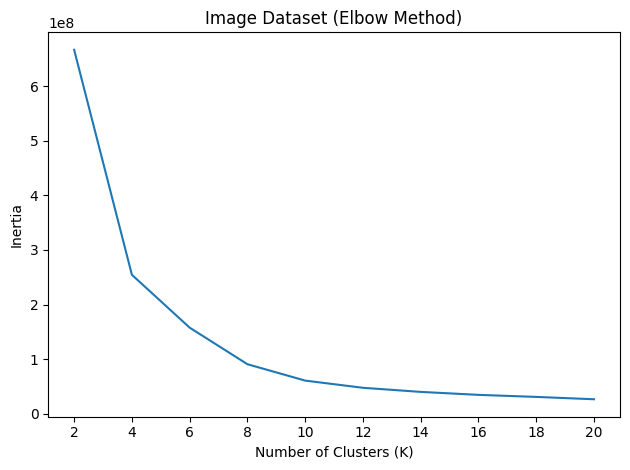

In [94]:
plt.rcParams["figure.autolayout"] = True
x = [2,4,6,8,10,12,14,16,18,20]
y = inertia
X = range(len(x))
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Image Dataset (Elbow Method)')
plt.plot(X, y)
plt.xticks(X, x)
plt.show()


In [101]:
silhouetteMetric = []

for i in range(0,10):
    silhouetteMetric.append(silhouette_score(data, selectedCluster[i][0]))

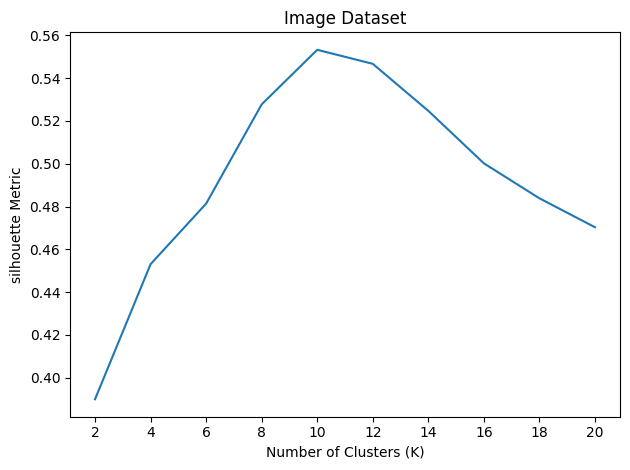

In [102]:
plt.rcParams["figure.autolayout"] = True
x = [2,4,6,8,10,12,14,16,18,20]
y = silhouetteMetric
X = range(len(x))
plt.xlabel('Number of Clusters (K)')
plt.ylabel('silhouette Metric')
plt.title('Image Dataset')
plt.plot(X, y)
plt.xticks(X, x)
plt.show()

In [97]:
selectedCluster[resultIndex][0]

array([3, 5, 6, ..., 6, 4, 3])

In [98]:
y=selectedCluster[resultIndex][0]
y=y+1

In [99]:
y

array([4, 6, 7, ..., 7, 5, 4])

In [100]:
#write file
with open(outputTxtLocation, 'w') as outputFile:
    for i in y:
        outputFile.write(str(i)+'\n')
print("Execution finished")

Execution finished
